# WBIC/BIC

This notebook gives a tutorial on how to use Watanabe-Bayesian information criterion (WBIC) and Bayesian information criterion (BIC) for feature selection (Watanabe[2010], McElreath[2015], and Vehtari[2016]). The WBIC or BIC is an information criterion. Similar to other criteria (AIC, DIC), the WBIC/BIC endeavors to find the most parsimonious model, i.e., the model that balances fit with complexity. In other words a model (or set of features) that optimizes WBIC/BIC should neither over nor under fit the available data. 

In this tutorial a data set is simulated using the damped linear trend (DLT) model. This data set is then used to fit DLT models with varying number of features as well as a global local trend model (GLT), and a Error-Trend-Seasonal (ETS) model. The WBIC/BIC criteria is then show to find the true model. 

Note that we recommend the use of WBIC for full Bayesian and SVI estimators and BIC for MAP estimator.

In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT
from orbit.utils.simulation import make_trend, make_regression

In [2]:
print(orbit.__version__)

1.1.4dev


## Data Simulation

This block of code creates random data set (365 observations with 10 features) assuming a DLT model. Of the 10 features 5 are effective regressors; i.e., they are used in the true model to create the data.

As an exercise left to the user once you have run the code once try changing the `NUM_OF_EFFECTIVE_REGRESSORS` (line 2), the `SERIES_LEN` (line 3), and the `SEED` (line 4) to see how it effects the results. 

In [3]:
NUM_OF_REGRESSORS = 10
NUM_OF_EFFECTIVE_REGRESSORS = 4
SERIES_LEN = 365
SEED = 1
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)

# combine trend and the regression
y = trend + regression
y = y - y.min()


x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)

x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt

In [4]:
print(df.shape)
print(df.head())

(365, 12)
          y        x1        x2        x3        x4        x5        x6  \
0  4.426242  0.172792  0.000000  0.165219 -0.000000 -1.956284  1.061930   
1  5.580432  0.452678  0.223187 -0.000000  0.290559  0.275263 -0.988209   
2  5.031773  0.182286  0.147066  0.014211  0.273356  0.613819 -1.198121   
3  3.264027 -0.368227 -0.081455 -0.241060  0.299423 -0.261870 -1.732015   
4  5.246511  0.019861 -0.146228 -0.390954 -0.128596 -0.410046 -1.152177   

         x7        x8        x9       x10       date  
0  0.116918 -0.019865 -0.109844 -2.244550 2016-01-10  
1  0.586367 -0.668872  0.558634 -1.211590 2016-01-17  
2 -0.170855 -0.115617 -0.217453 -0.217460 2016-01-24  
3 -0.142948  0.247400  0.580755  1.639177 2016-01-31  
4  0.179797  0.306605 -0.454966  1.033073 2016-02-07  


## WBIC

In this section, we use DLT model as an example. Different DLT models (the number of features used changes) are fitted and their WBIC values are calculated respectively.

In [5]:
%%time
WBIC_ls = []
for k in range(1, NUM_OF_REGRESSORS + 1):
    regressor_col = x_cols[:k]
    dlt_mod = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
        )
    WBIC_temp = dlt_mod.fit_wbic(df=df) 
    print("WBIC value with {:d} regressors: {:.3f}".format(k, WBIC_temp))
    print('------------------------------------------------------------------')
    WBIC_ls.append(WBIC_temp)

16:48:40 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:48:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:48:49 - cmdstanpy - INFO - CmdStan done processing.


16:48:51 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:48:51 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 1 regressors: 1201.735
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:01 - cmdstanpy - INFO - CmdStan done processing.


16:49:03 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:49:03 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 2 regressors: 1150.356
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:13 - cmdstanpy - INFO - CmdStan done processing.


16:49:15 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:49:16 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 3 regressors: 1103.973
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:25 - cmdstanpy - INFO - CmdStan done processing.


16:49:27 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:49:27 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 4 regressors: 1054.947
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:37 - cmdstanpy - INFO - CmdStan done processing.


16:49:39 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:49:39 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 5 regressors: 1061.265
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:49:49 - cmdstanpy - INFO - CmdStan done processing.


16:49:51 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:49:51 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 6 regressors: 1066.943
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:01 - cmdstanpy - INFO - CmdStan done processing.


16:50:03 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:50:03 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 7 regressors: 1071.988
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:12 - cmdstanpy - INFO - CmdStan done processing.


16:50:15 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:50:15 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 8 regressors: 1079.814
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:24 - cmdstanpy - INFO - CmdStan done processing.


16:50:26 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:50:26 - cmdstanpy - INFO - CmdStan start processing


WBIC value with 9 regressors: 1086.051
------------------------------------------------------------------


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:35 - cmdstanpy - INFO - CmdStan done processing.



WBIC value with 10 regressors: 1092.341
------------------------------------------------------------------
CPU times: user 23 s, sys: 1.19 s, total: 24.2 s
Wall time: 1min 57s


It is also interesting to see if WBIC can distinguish between model types; not just do feature selection for a given type of model. To that end the next block fits an LGT and ETS model to the data; the WBIC values for both models are then calculated.  

Note that WBIC is supported for both  the 'stan-mcmc' and 'pyro-svi' estimators. Currently only the LGT model has both. Thus WBIC is calculated for LGT for both estimators. 

In [6]:
%%time
lgt = LGT(response_col=response_col,
          date_col=dt_col,
          regressor_col=regressor_col,
          seasonality=52,
          estimator='stan-mcmc',
          seed=8888)
WBIC_lgt_mcmc = lgt.fit_wbic(df=df) 
print("WBIC value for LGT model (stan MCMC): {:.3f}".format(WBIC_lgt_mcmc))

lgt = LGT(response_col=response_col,
          date_col=dt_col,
          regressor_col=regressor_col,
          seasonality=52,
          estimator='pyro-svi',
          seed=8888)
WBIC_lgt_pyro = lgt.fit_wbic(df=df) 
print("WBIC value for LGT model (pyro SVI): {:.3f}".format(WBIC_lgt_pyro))

ets = ETS(
        response_col=response_col,
        date_col=dt_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
    )

WBIC_ets = ets.fit_wbic(df=df) 
print("WBIC value for ETS model: {:.3f}".format(WBIC_ets))

WBIC_ls.append(WBIC_lgt_mcmc)
WBIC_ls.append(WBIC_lgt_pyro)
WBIC_ls.append(WBIC_ets)

16:50:38 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:50:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:50:39 - cmdstanpy - INFO - CmdStan done processing.
16:50:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lgt_model_namespace::log_prob: l[1] is -1.08324, but must be greater than or equal to 0.000000 (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/lgt.stan', line 130, column 2 to column 32)
	Exception: lgt_model_namespace::log_prob: l[1] is -9.8205, but must be greater than or equal to 0.000000 (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/lgt.stan', line 130, column 2 to column 32)
	Exception: lgt_model_namespace::log_prob: l[1] is -7.17958, but must be greater than or equal to 0.000000 (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/lgt.stan', line 130, column 2 to column 32)
Exception: lgt_model_namespace::log_prob: l[1] is -294.617, but must be greater than or equal to 0.000000 (in '/Users/towinazure/edwinnglabs/orbit/orbit/stan/lgt.stan', line 130, column 2 to column 32)
	Exception: lgt_model_namespace::log_prob: l[1] is -2.82877, but must 


WBIC value for LGT model (stan MCMC): 1142.021


DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/3ohdaxjo.json
16:51:02 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
INFO:cmdstanpy:Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
DEBUG:cmdstanpy:cmd: /Users/towinazure/edwinnglabs/orbit/orbit/stan/ets info
cwd: None
16:51:02 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


WBIC value for LGT model (pyro SVI): 1131.733


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/towinazure/edwinnglabs/orbit/orbit/stan/ets', 'id=4', 'random', 'seed=2020', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/3ohdaxjo.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/etslnf8s2jw/ets-20230106165102_4.csv', 'method=sample', 'num_samples=25', 'num_warmup=225', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/Users/towinazure/edwinnglabs/orbit/orbit/stan/ets', 'id=2', 'random', 'seed=2020', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/3ohdaxjo.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/etslnf8s2jw/ets-20230

16:51:02 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/towinazure/edwinnglabs/orbit/orbit/stan/ets', 'id=1', 'random', 'seed=2020', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/3ohdaxjo.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/etslnf8s2jw/ets-20230106165102_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=225', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/etslnf8s2jw/ets-20230106165102_1.csv
 console_msgs (if any):
	/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/etslnf8s2jw/ets-20230106165102_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 225
 


WBIC value for ETS model: 1201.702
CPU times: user 22 s, sys: 3.33 s, total: 25.4 s
Wall time: 24.4 s


The plot below shows the WBIC vs the number of features / model type (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value. The minimum is at the true value. 

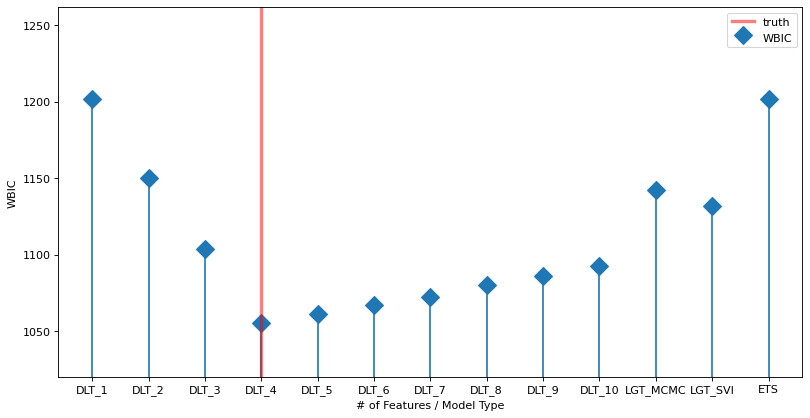

In [7]:
labels = ["DLT_{}".format(x) for x in range(1, NUM_OF_REGRESSORS + 1)] + ['LGT_MCMC', 'LGT_SVI','ETS']
fig, ax = plt.subplots(1, 1,figsize=(12, 6), dpi=80)
markerline, stemlines, baseline = ax.stem(
    np.arange(len(labels)), np.array(WBIC_ls), label='WBIC', markerfmt='D')
baseline.set_color('none')
markerline.set_markersize(12)
ax.set_ylim(1020, )
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# because list type is mixed index from 1;
ax.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS - 1, color='red', linewidth=3, alpha=0.5, linestyle='-', label='truth') 
ax.set_ylabel("WBIC")
ax.set_xlabel("# of Features / Model Type")
ax.legend();

## BIC

In this section, we use DLT model as an example. Different DLT models (the number of features used changes) are fitted and their BIC values are calculated respectively.

In [8]:
%%time
BIC_ls = []
for k in range(0, NUM_OF_REGRESSORS):
    regressor_col = x_cols[:k + 1]
    dlt_mod = DLT(
        estimator='stan-map',
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        )
    dlt_mod.fit(df=df)
    BIC_temp = dlt_mod.get_bic() 
    print("BIC value with {:d} regressors: {:.3f}".format(k + 1, BIC_temp))
    print('------------------------------------------------------------------')
    BIC_ls.append(BIC_temp)

DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/8zoxoi16.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/6ka6odn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/towinazure/edwinnglabs/orbit/orbit/stan/dlt', 'random', 'seed=2022', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/8zoxoi16.json', 'init=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/6ka6odn5.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dltd0c3brdi/dlt-20230106165102.csv', 'method=optimize']
16:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/f3mw3kwv.jso

BIC value with 1 regressors: 1247.444
------------------------------------------------------------------
BIC value with 2 regressors: 1191.902
------------------------------------------------------------------
BIC value with 3 regressors: 1139.408
------------------------------------------------------------------


DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/i6j3lijk.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dh61qq3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/towinazure/edwinnglabs/orbit/orbit/stan/dlt', 'random', 'seed=2022', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/i6j3lijk.json', 'init=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dh61qq3y.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dltzyd3bqbg/dlt-20230106165103.csv', 'method=optimize']
16:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/wtsf3_sv.jso

BIC value with 4 regressors: 1079.642
------------------------------------------------------------------
BIC value with 5 regressors: 1082.418
------------------------------------------------------------------
BIC value with 6 regressors: 1082.366
------------------------------------------------------------------


16:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/kq981gxs.json
DEBUG:cmdstanpy:input tempfile: /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dj1cgq8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/towinazure/edwinnglabs/orbit/orbit/stan/dlt', 'random', 'seed=2022', 'data', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/kq981gxs.json', 'init=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dj1cgq8b.json', 'output', 'file=/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/tmpkkkhy8l6/dltvfgxu7ku/dlt-20230106165103.csv', 'method=optimize']
16:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cm

BIC value with 7 regressors: 1082.221
------------------------------------------------------------------
BIC value with 8 regressors: 1081.726
------------------------------------------------------------------
BIC value with 9 regressors: 1081.526
------------------------------------------------------------------


16:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BIC value with 10 regressors: 1189.381
------------------------------------------------------------------
CPU times: user 413 ms, sys: 412 ms, total: 825 ms
Wall time: 823 ms


The plot below shows the BIC vs the number of features (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value. The minimum is at the true value. 

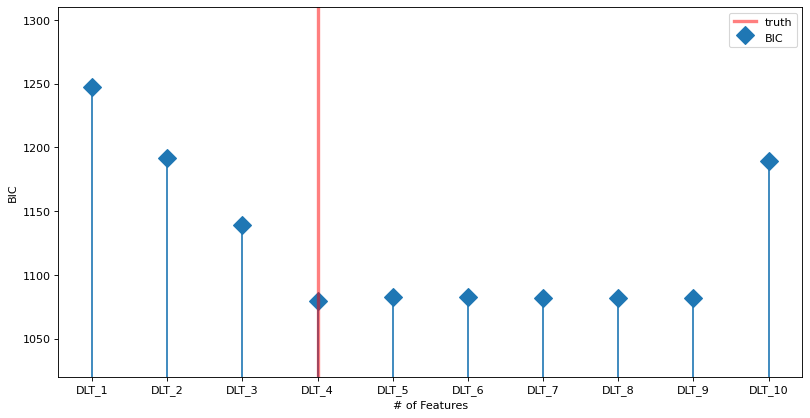

In [9]:
labels = ["DLT_{}".format(x) for x in range(1, NUM_OF_REGRESSORS + 1)]
fig, ax = plt.subplots(1, 1,figsize=(12, 6), dpi=80)
markerline, stemlines, baseline = ax.stem(
    np.arange(len(labels)), np.array(BIC_ls), label='BIC', markerfmt='D')
baseline.set_color('none')
markerline.set_markersize(12)
ax.set_ylim(1020, )
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
# because list type is mixed index from 1;
ax.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS - 1, color='red', linewidth=3, alpha=0.5, linestyle='-', label='truth') 
ax.set_ylabel("BIC")
ax.set_xlabel("# of Features")
ax.legend();

## References

1. Watanabe Sumio (2010). "Asymptotic Equivalence of Bayes Cross Validation and Widely Applicable Information Criterion in Singular Learning Theory". Journal of Machine Learning Research. 11: 3571–3594.
2. McElreath Richard (2015). "Statistical Rethinking: A Bayesian course with examples in R and Stan" Secound Ed. 193-221.
3. Vehtari Aki, Gelman Andrew, Gabry Jonah (2016) "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC"
